In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score , confusion_matrix


from google.colab import files

uploaded = files.upload()

df = pd.read_csv('workout_fitness_tracker_data.csv')

df.head()

Saving workout_fitness_tracker_data.csv to workout_fitness_tracker_data.csv


,User ID,Age,Gender,Height (cm),Weight (kg),Workout Type,Workout Duration (mins),Calories Burned,Heart Rate (bpm),Steps Taken,Distance (km),Workout Intensity,Sleep Hours,Water Intake (liters),Daily Calories Intake,Resting Heart Rate (bpm),VO2 Max,Body Fat (%),Mood Before Workout,Mood After Workout
0,1,39,Male,175,99,Cycling,79,384,112,8850,14.44,High,8.2,1.9,3195,61,38.4,28.5,Tired,Fatigued
1,2,36,Other,157,112,Cardio,73,612,168,2821,1.10,High,8.6,1.9,2541,73,38.4,28.5,Happy,Energized
2,3,25,Female,180,66,HIIT,27,540,133,18898,7.28,High,9.8,1.9,3362,80,38.4,28.5,Happy,Fatigued
3,4,56,Male,154,89,Cycling,39,672,118,14102,6.55,Medium,5.8,1.9,2071,65,38.4,28.5,Neutral,Neutral
4,5,53,Other,194,59,Strength,56,410,170,16518,3.17,Medium,7.3,1.9,3298,59,38.4,28.5,Stressed,Energized


In [3]:
df.isnull().sum()

,0
User ID,0
Age,0
Gender,0
Height (cm),0
Weight (kg),0
Workout Type,0
Workout Duration (mins),0
Calories Burned,0
Heart Rate (bpm),0
Steps Taken,0


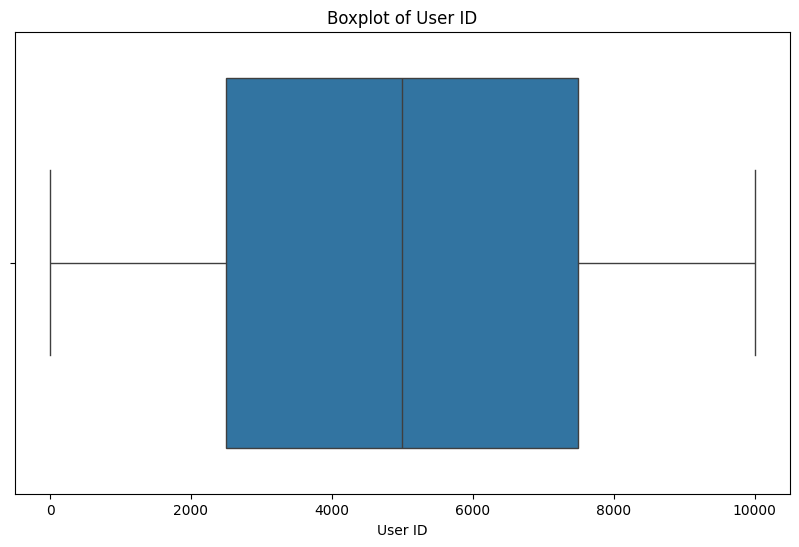

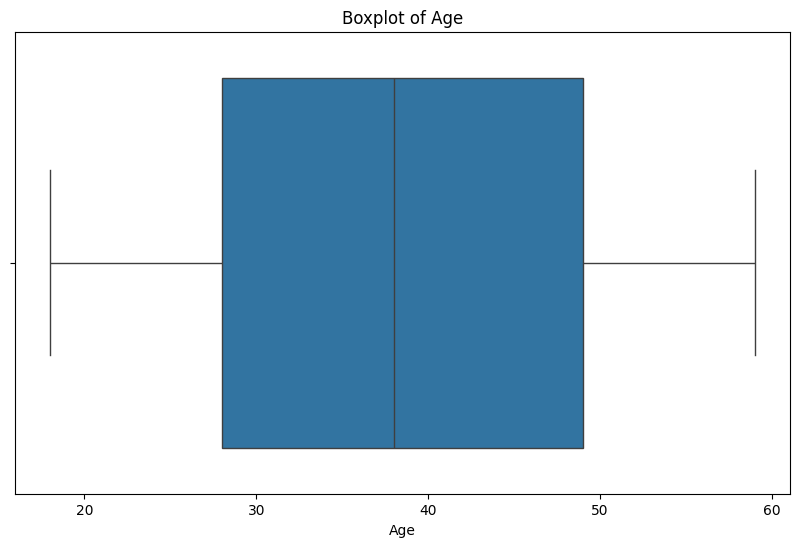

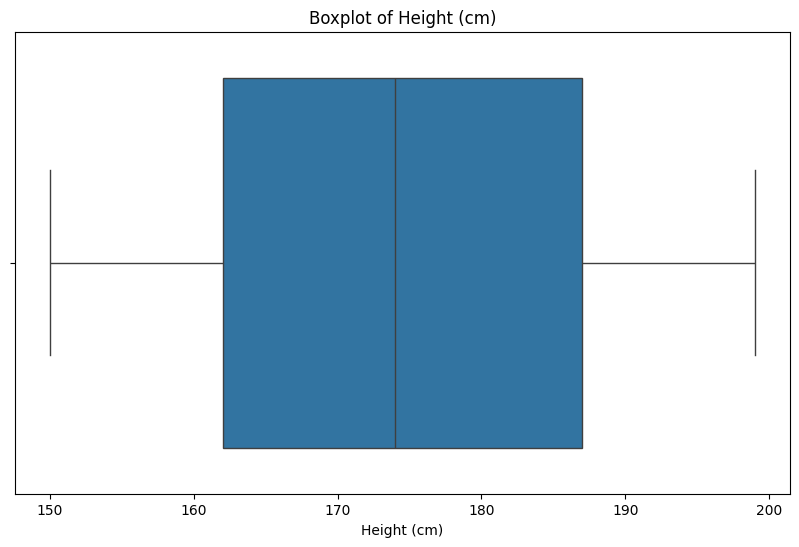

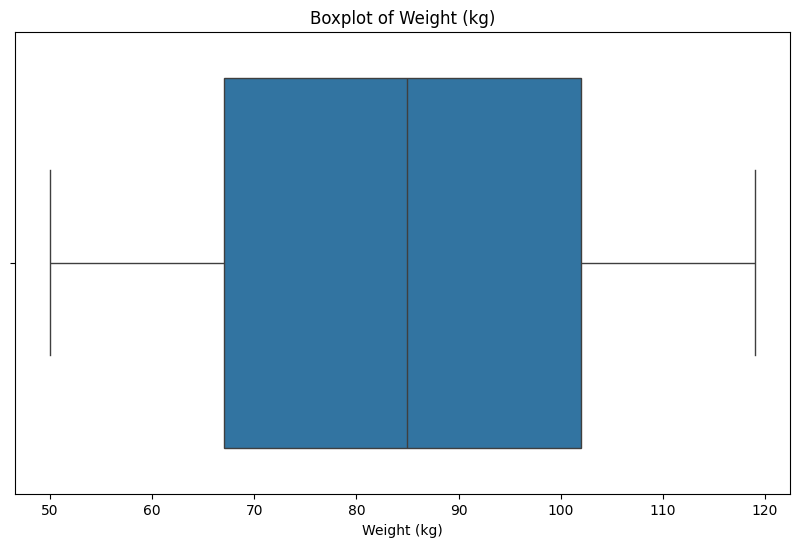

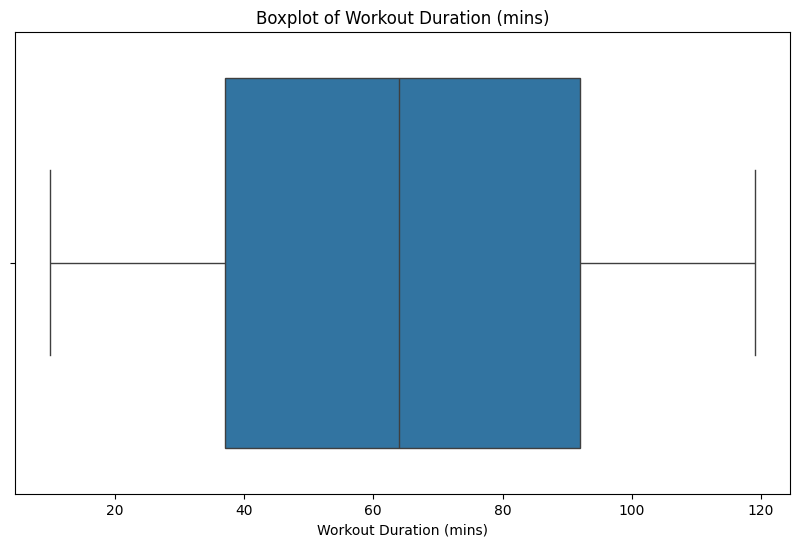

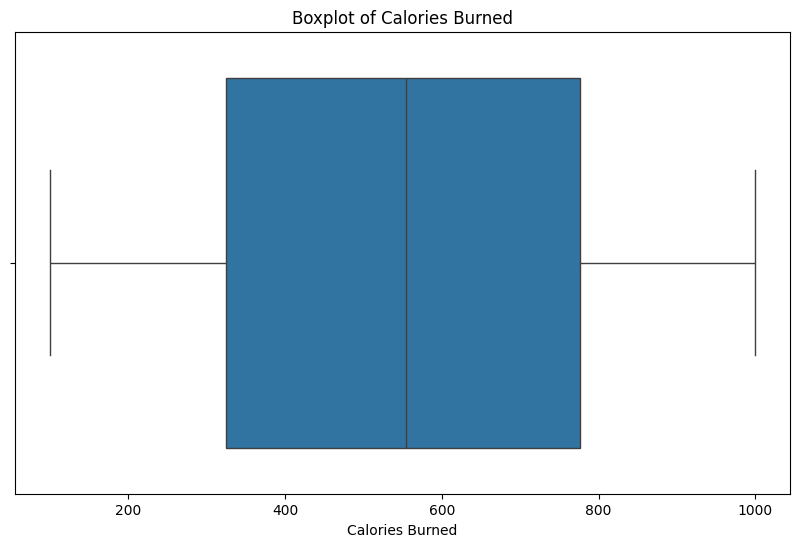

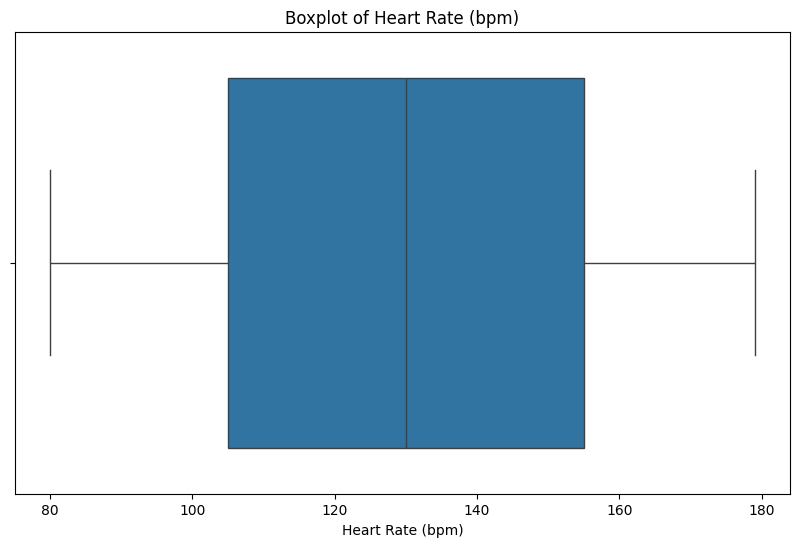

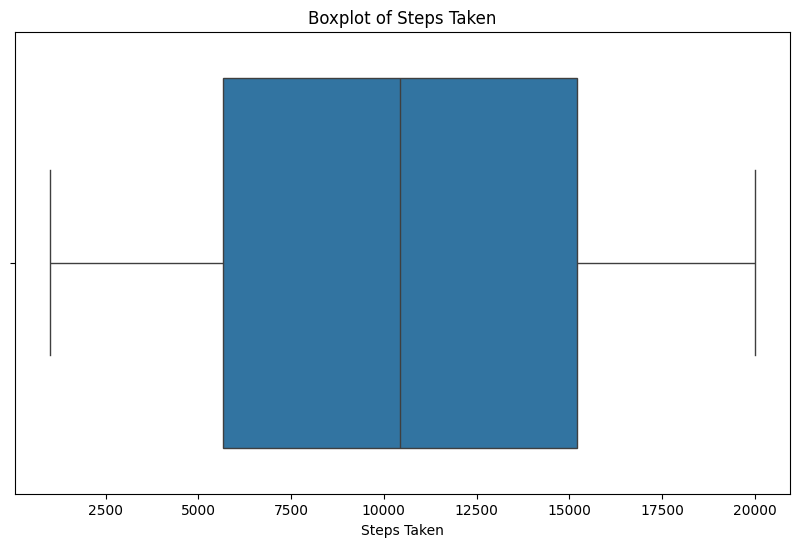

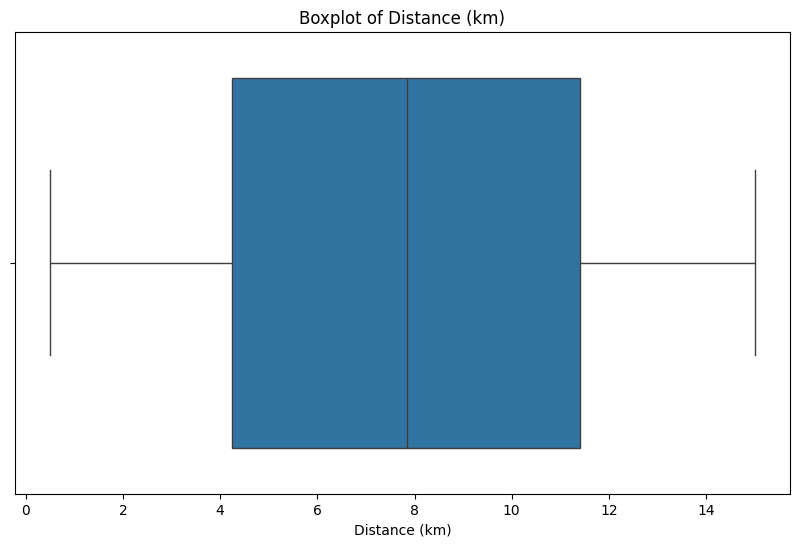

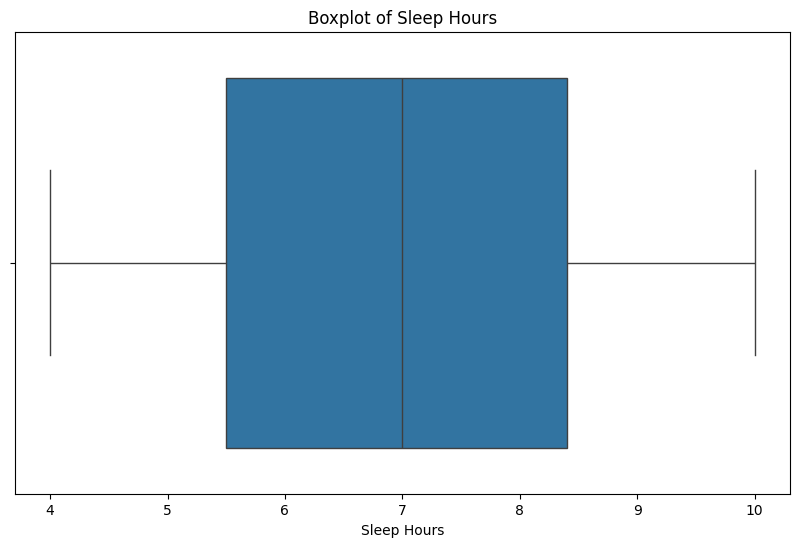

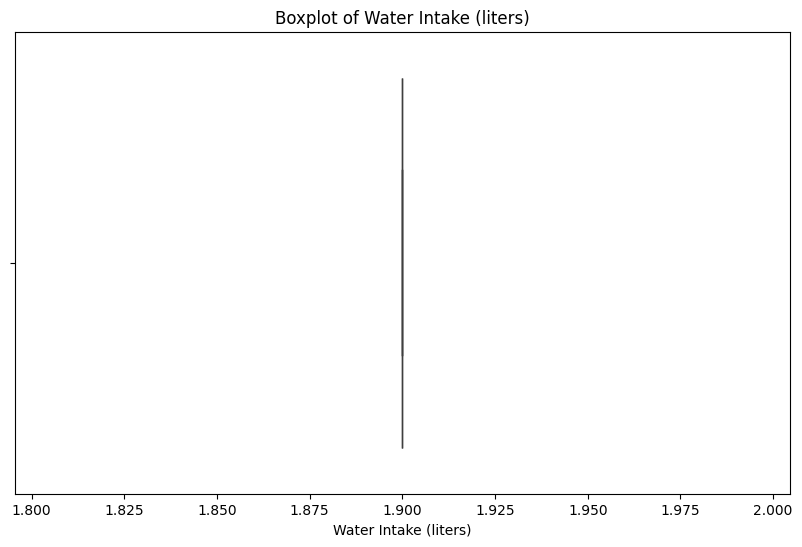

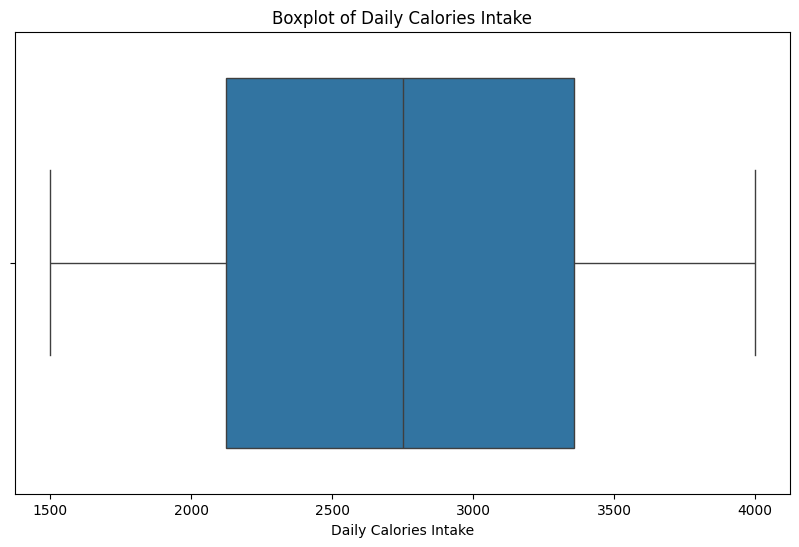

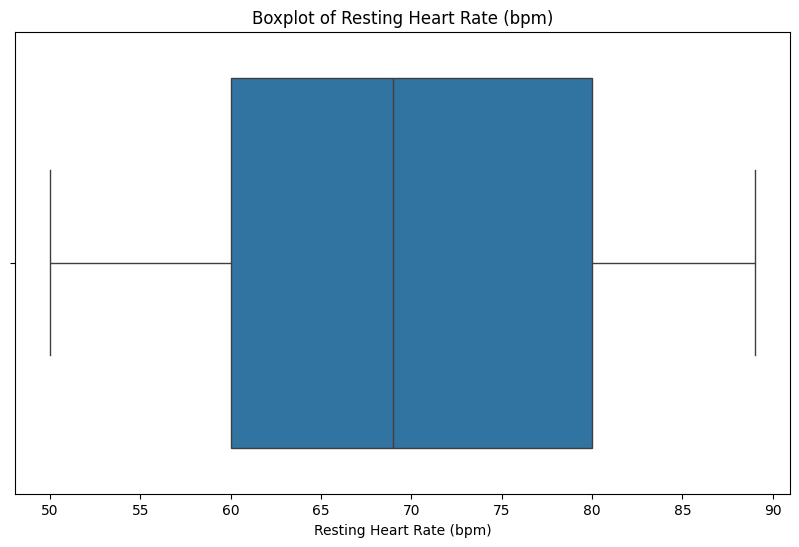

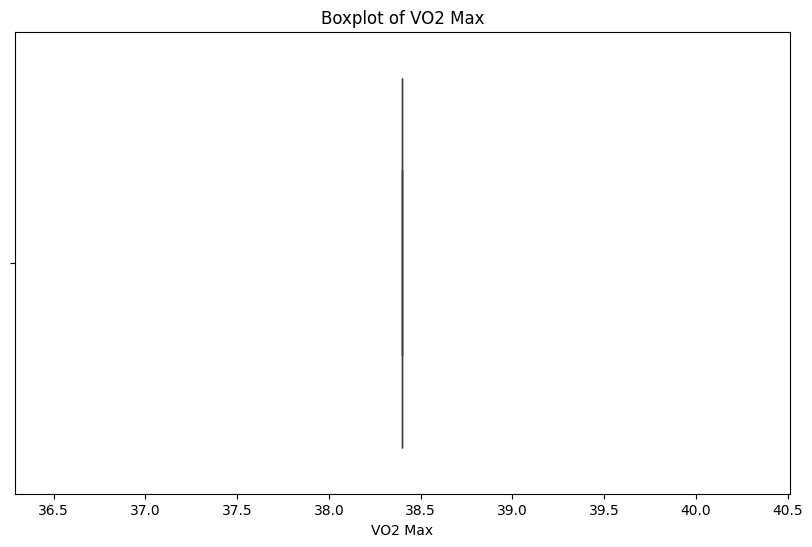

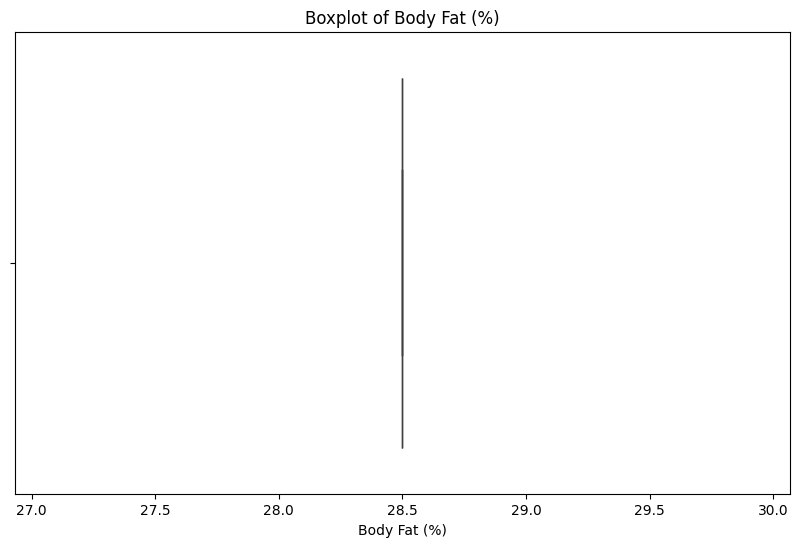

In [5]:
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
for col in numerical_cols:
  plt.figure(figsize=(10,6))
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  plt.show()

In [6]:
def generate_dropout_label(row):
    before = row['Mood Before Workout']
    after = row['Mood After Workout']
    intensity = row['Workout Intensity']
    duration = row['Workout Duration (mins)']

    if (
        before in ['Tired', 'Stressed'] and
        after in ['Fatigued', 'Neutral'] and
        intensity in ['Low'] and
        duration < 30
    ):
        return 1
    return 0

In [7]:
if 'User ID' in df.columns:
    df.drop('User ID', axis=1, inplace=True)
df['Dropout'] = df.apply(generate_dropout_label, axis=1)

categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

numerical_cols = numerical_cols.drop('Dropout')

X = df.drop(columns=['Dropout'])
y = df['Dropout']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
])
X_new = preprocessor.fit_transform(X)

In [8]:
X_train , X_test , y_train , y_test = train_test_split(X_new , y , test_size=0.2 , random_state=42, stratify=y)

In [9]:

class WorkoutDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        if hasattr(X, "toarray"):
            X = X.toarray()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_data = WorkoutDataset(X_train, y_train)
test_data = WorkoutDataset(X_test, y_test)

train_load = DataLoader(train_data, batch_size=64, shuffle=True)
test_load = DataLoader(test_data, batch_size=256)


class FNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

model = FNN(input_size=X_train.shape[1])


def model_training(model, train_load, test_load, epochs=30, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for Xa, ya in train_load:
            Xa, ya = Xa.to(device), ya.to(device)
            optimizer.zero_grad()
            y_pred = model(Xa)
            loss = criterion(y_pred, ya)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * Xa.size(0)

        train_loss /= len(train_load.dataset)

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for Xa, ya in test_load:
                Xa, ya = Xa.to(device), ya.to(device)
                y_pred = model(Xa).cpu().numpy()
                all_preds.append(y_pred)
                all_labels.append(ya.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        pred_labels = (all_preds >= 0.5).astype(int)

        acc = accuracy_score(all_labels, pred_labels)
        prec = precision_score(all_labels, pred_labels, zero_division=0)
        rec = recall_score(all_labels, pred_labels, zero_division=0)
        f1 = f1_score(all_labels, pred_labels, zero_division=0)

        print(f"Epoch {epoch:02d} | Loss: {train_loss:.4f} | Acc: {acc:.4f} | "
              f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


model_training(model, train_load, test_load, epochs=10)



Epoch 01 | Loss: 0.5765 | Acc: 0.9820 | Precision: 0.5806 | Recall: 0.4390 | F1: 0.5000
Epoch 02 | Loss: 0.2528 | Acc: 0.9845 | Precision: 1.0000 | Recall: 0.2439 | F1: 0.3922
Epoch 03 | Loss: 0.0994 | Acc: 0.9890 | Precision: 0.9524 | Recall: 0.4878 | F1: 0.6452
Epoch 04 | Loss: 0.0601 | Acc: 0.9920 | Precision: 0.9310 | Recall: 0.6585 | F1: 0.7714
Epoch 05 | Loss: 0.0450 | Acc: 0.9870 | Precision: 1.0000 | Recall: 0.3659 | F1: 0.5357
Epoch 06 | Loss: 0.0415 | Acc: 0.9940 | Precision: 0.8537 | Recall: 0.8537 | F1: 0.8537
Epoch 07 | Loss: 0.0339 | Acc: 0.9930 | Precision: 0.9355 | Recall: 0.7073 | F1: 0.8056
Epoch 08 | Loss: 0.0306 | Acc: 0.9930 | Precision: 0.8649 | Recall: 0.7805 | F1: 0.8205
Epoch 09 | Loss: 0.0244 | Acc: 0.9945 | Precision: 0.9167 | Recall: 0.8049 | F1: 0.8571
Epoch 10 | Loss: 0.0217 | Acc: 0.9925 | Precision: 0.9333 | Recall: 0.6829 | F1: 0.7887
